## Biulding a music genre classifier using HuggingFace pre-trained models

This notebook is based on HuggingFace audio course.

## Needed Libraries

In [2]:
## Needed Libraries


# For Data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



#Audio
import librosa
import librosa.display

from IPython.display import Audio



#from IPython.display import Audio

!pip install datasets
from datasets import load_dataset, Audio


# transformers
!pip install git+https://github.com/huggingface/transformers
!pip install -U transformers
!pip install evaluate

#the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`. So we need one the below lines
!pip install -U accelerate
#pip install transformers[torch]



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-1qcppsaz
  Running command git clone --filter=blob:none --quiet https://github.com/h

In [3]:
# To get the notebook connected to google drive
from google.colab import drive

# mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


## FMA Dataset

In [ ]:
# loading dataset
size = "small"

#download gtzan


Dataset = load_dataset("hkamath-rudra/fma", size)


KeyboardInterrupt: 

In [ ]:
# saving dataset
Dataset.save_to_disk('/content/drive/My Drive/datasets/FMA_small')

There are several tracks that need to be removed, as they can't be decoded properly and will cause the model crash. Dylan spotted them. I'm using Dylan's code to remove them. These tracks are the following:

In [ ]:
small_train [3495, 3496, 3497, 3530, 3897, 5611]
#med_train = [146, 7638, 8878, 8879, 8880, 8881, 8882, 8883, 9301, 11215, 11290, 12713]
#med_validation = [817]
#med_test = [87]

In [ ]:
def track_remover(split, idx):
    # create new dataset exluding those idx
    return Dataset[split].select(
        (
            i for i in range(len(Dataset[split]))
            if i not in set(idx)
        )
    )

In [ ]:
split = 'train'
Dataset[split] = track_remover(split, [3495, 3496, 3497, 3530, 3897, 5611])
Dataset

In [ ]:
directory_path = "/content/drive/MyDrive/Colab Notebooks/FMA Small"

Dataset.save_to_disk(directory_path)

### Loading the FMA dataset and Preprocessing

Downloading the GTZAN Dataset and Preprocessing

In [1]:
from datasets import load_dataset

gtzan = load_dataset("marsyas/gtzan", "all")
gtzan

ModuleNotFoundError: No module named 'datasets'

In [ ]:
from datasets import load_from_disk

directory_path = "/content/drive/MyDrive/Colab Notebooks/FMA Small"

#Load the dataset from the disk
FMA = load_from_disk(directory_path)

In [ ]:
FMA

DatasetDict({
    train: Dataset({
        features: ['audio', 'track.genre_top'],
        num_rows: 6394
    })
    validation: Dataset({
        features: ['audio', 'track.genre_top'],
        num_rows: 800
    })
    test: Dataset({
        features: ['audio', 'track.genre_top'],
        num_rows: 800
    })
})

For DistilHuBERT we need only genre and the information in `audio` column. So I keep `audio` and `track.genre_top`.

Let's look at the dataset to see the distribution of genres.

In [ ]:
from collections import Counter

FMA_genre = FMA.select_columns(['track.genre_top'])
FMA_genre['train'].to_pandas().value_counts()

track.genre_top
Folk               800
Instrumental       800
International      800
Pop                800
Electronic         799
Experimental       799
Rock               799
Hip-Hop            797
Name: count, dtype: int64

We can see that genres are almost evenly distributed across the train dataset. Let's make sure that is the case for our validation and test dataset.

In [ ]:
FMA_genre['validation'].to_pandas().value_counts()

track.genre_top
Electronic         100
Experimental       100
Folk               100
Hip-Hop            100
Instrumental       100
International      100
Pop                100
Rock               100
Name: count, dtype: int64

In [ ]:
FMA_genre['test'].to_pandas().value_counts()

track.genre_top
Electronic         100
Experimental       100
Folk               100
Hip-Hop            100
Instrumental       100
International      100
Pop                100
Rock               100
Name: count, dtype: int64

Looks good! This tells me I can choose accuracy as a proper metric to evaluate my model. We are almost done with preprocessing. We just need to convert our data to a format readable for our model: DistillHuBERT .

## GTZAN Dataset

In [4]:
from datasets import load_dataset

gtzan = load_dataset("marsyas/gtzan", "all")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

gtzan.py:   0%|          | 0.00/3.35k [00:00<?, ?B/s]

The repository for marsyas/gtzan contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/marsyas/gtzan.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] Y


genres.tar.gz:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 999
    })
})

Let's have a look

In [5]:
gtzan

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 999
    })
})

Let's look at the dataset to see the distribution of genres.

In [11]:
from collections import Counter

gtzan_genre = gtzan.select_columns(['genre'])
gtzan_genre['train'].to_pandas().value_counts()

,count
genre,
0,100
1,100
2,100
3,100
4,100
6,100
8,100
7,100
9,100


<Axes: xlabel='genre'>

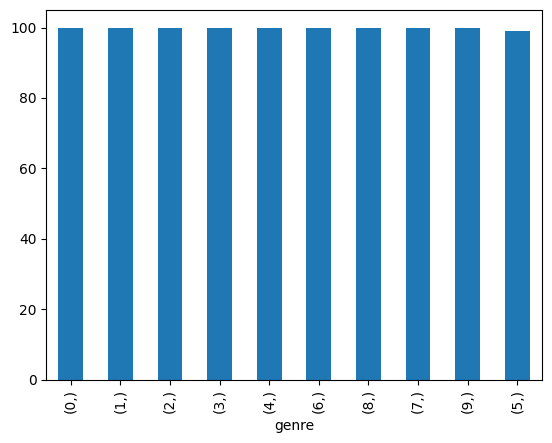

In [12]:
#plot histogram of genres
gtzan_genre['train'].to_pandas().value_counts().plot(kind='bar')

In [13]:
# Look at genres
gtzan['train'].features['genre'].names

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

The dataset is balanced across genres. This tells me I can choose `accuracy` to evaluate my model.


Here we can use the `train_test_split()` method to quickly create a 90/10 validation split as follows:

In [14]:
gtzan = gtzan["train"].train_test_split(seed=42, shuffle=True, test_size=0.1)
gtzan

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 899
    })
    test: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 100
    })
})

Great, now that we’ve got our training and validation sets, let’s take a look at one of the audio files

In [58]:
sample =gtzan["train"][56]
sample

{'file': '/root/.cache/huggingface/datasets/downloads/extracted/3b204381d6c029312e4f9c569c6b1130af3041dd36ca38ca53d4e20f585e39c6/genres/blues/blues.00066.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/3b204381d6c029312e4f9c569c6b1130af3041dd36ca38ca53d4e20f585e39c6/genres/blues/blues.00066.wav',
  'array': array([ 0.07894897,  0.13638306,  0.13336182, ..., -0.01293945,
         -0.00521851,  0.00741577]),
  'sampling_rate': 22050},
 'genre': 0}

In [27]:
# play the sample
from IPython.display import Audio

# Extract the audio array and sampling rate
audio_array = sample["audio"]["array"]
sampling_rate = sample["audio"]["sampling_rate"]

# Play the audio
Audio(audio_array, rate=sampling_rate)


What genre do you think it is :-D?

Let’s use the int2str() method of the genre feature to map these integers to human-readable names:

In [59]:
id2label_fn = gtzan["train"].features["genre"].int2str
id2label_fn(sample["genre"])

'blues'

## Converting Audio to Proper Input Format for DistillHuBERT

You can refer to the DistillHuBERT documentation for more information about the following parameters.


In [28]:
from transformers import Wav2Vec2FeatureExtractor

model_id = "ntu-spml/distilhubert"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(
    model_id,
    feature_extractor_type="Wav2Vec2FeatureExtractor",
    feature_size=1,
    padding_side="right",
    padding_value=0,
    return_attention_mask=True,
    sampling_rate=16000
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

In [29]:
# Alternatively, we can use AutoFeatureExtractor

#from transformers import AutoFeatureExtractor

#model_id = "ntu-spml/distilhubert"
#feature_extractor = AutoFeatureExtractor.from_pretrained(
#    model_id, do_normalize=True, return_attention_mask=True
#)

The sampling rate of the model`ntu-spml/distilhubert`and the dataset should be the same before passing the data to feature extractor. The sample rate of the model is 16000 Hz:

In [ ]:
sampling_rate = feature_extractor.sampling_rate
sampling_rate

16000

Now I resampled the dataset using the `cast_column()` and `Audio` methods. However, this step may not be necessary, as the preprocessing function we use later performs the same operation.

In [47]:
from datasets import Audio
gtzan_resampled = gtzan.cast_column("audio", Audio(sampling_rate=16000))

In [60]:
#Have a look at the resampled dataset
gtzan_resampled['train'].features

{'file': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'genre': ClassLabel(names=['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'], id=None)}

In [61]:
# a preprocess function to be applied to dataset:
# it normalizes the dataset and ensures that the sampeling rate is 16000 and max length is 30s

max_duration = 30.0


def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
    )
    return inputs

With this function defined, we can now apply it to the dataset using the `map()` method.

In [63]:
gtzan_encoded = gtzan.map(
    preprocess_function,
    remove_columns=['audio'],
    batched=True,
    batch_size=100,
    num_proc=1,
)

Map:   0%|          | 0/899 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [64]:
gtzan_encoded

DatasetDict({
    train: Dataset({
        features: ['file', 'genre', 'input_values', 'attention_mask'],
        num_rows: 899
    })
    test: Dataset({
        features: ['file', 'genre', 'input_values', 'attention_mask'],
        num_rows: 100
    })
})

To simplify the training, we’ve removed the audio and file columns from the dataset. The input_values column contains the encoded audio files, the attention_mask a binary mask of 0/1 values that indicate where we have padded the audio input, and the genre column contains the corresponding labels (or targets). To enable the Trainer to process the class labels, we need to rename the genre column to label:

In [66]:
gtzan_encoded = gtzan_encoded.rename_column("genre", "label")

Finally, we need to obtain the label mappings from the dataset. This mapping will take us from integer ids (e.g. 7) to human-readable class labels (e.g. "pop") and back again. In doing so, we can convert our model’s integer id prediction into human-readable format, enabling us to use the model in any downstream application. We can do this by using the int2str() method as follows:

In [ ]:
id2label = {
    str(i): id2label_fn(i)
    for i in range(len(gtzan_encoded["train"].features["label"].names))
}
label2id = {v: k for k, v in id2label.items()}

id2label["7"]

## Loading the Model

Following huggingface audio course, I load a model using the `AutoModelForAudioClassification` class, which will automatically add the appropriate classification head to the pretrained distilHuBERT model.

In [65]:
from transformers import AutoModelForAudioClassification

num_labels = len(id2label)

model = AutoModelForAudioClassification.from_pretrained(
    model_id,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
)

config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/94.0M [00:00<?, ?B/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at ntu-spml/distilhubert and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The next step is to define the training parameters: the batch size, gradient accumulation steps, number of training epochs and learning rate...

In [76]:
from transformers import TrainingArguments

model_name = model_id.split("/")[-1]
batch_size = 8
gradient_accumulation_steps = 1
num_train_epochs = 10

training_args = TrainingArguments(
    f"{model_name}-finetuned-gtzan",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    push_to_hub=False,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


The last thing we need to do is define the metrics. Since the dataset is balanced, we’ll use accuracy as our metric and load it using the Evaluate library:

In [77]:
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

## Trainin_Metric: Accuracy

In [80]:
import os

# Disable W&B logging
os.environ["WANDB_MODE"] = "disabled"

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=gtzan_encoded["train"],
    eval_dataset=gtzan_encoded["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

trainer.train()

<ipython-input-81-54444099d7e6>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


In [ ]:
trainer = Trainer(
    args=TrainingArguments(
        output_dir="./results",
        logging_dir=None,  # Disable W&B logging
        report_to="none",  # Disable reporting to any third-party tools
        # other arguments
    ),
    # other Trainer arguments
)


In [ ]:
model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/FMA_Hubert_Wav2Vec/final_model_accuracy')
feature_extractor.save_pretrained('/content/drive/MyDrive/Colab Notebooks/Model_Hubert_Wav2Vec/final_model_accuracy')


NameError: name 'model' is not defined